# Libraries & Settings

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

In [3]:
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import qgrid
from datetime import datetime as dtt

from pa_lib.file import (
    data_files,
    load_bin,
    store_bin,
    load_csv,
    write_xlsx,
    load_xlsx,
    set_project_dir,
    project_dir,
)
from pa_lib.data import (
    calc_col_partitioned,
    clean_up_categoricals,
    unfactorize,
    flatten,
    replace_col,
    cond_col,
    desc_col,
    unfactorize,
    as_dtype,
    flatten_multi_index_cols,
)
from pa_lib.util import obj_size, cap_words, normalize_rows, clear_row_max
from pa_lib.log import time_log, info
from pa_lib.vis import dive

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)


def qshow(df, fit_width=False):
    return qgrid.show_grid(
        df, grid_options={"forceFitColumns": fit_width, "fullWidthRows": False}
    )

# Load data

In [4]:
set_project_dir("vkprog")

## Buchungsdaten

In [5]:
bd_raw = load_bin("bd_data.feather").rename(
    mapper=lambda name: cap_words(name, sep="_"), axis="columns"
)
bd = bd_raw.loc[(bd_raw.Netto > 0)].pipe(clean_up_categoricals)

2019-09-12 12:13:59 [INFO] Reading from file C:\Users\kpf\data\vkprog\bd_data.feather
2019-09-12 12:13:59 [INFO] Finished loading binary file in 0.22s (0.84s CPU)


In [6]:
desc_col(bd)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,category,0/675655,32264
Endkunde,category,0/675655,30329
EK_Abc,category,1154/674501,8
EK_Boni,category,76/675579,3
EK_Plz,category,164/675491,2975
EK_Ort,category,164/675491,3023
EK_Land,category,164/675491,46
EK_HB_Apg_Kurzz,category,27740/647915,90
EK_Aktiv,category,0/675655,2
Agentur,category,322785/352870,3970


## Dispo dates

In [52]:
dispo = load_bin("dispo.feather").set_index('Dispo')
dispo.head()

2019-09-12 13:31:37 [INFO] Reading from file C:\Users\kpf\data\vkprog\dispo.feather
2019-09-12 13:31:37 [INFO] Finished loading binary file in 0.0s (0.02s CPU)


,KAM_open_date,open_date,Jahr,KAM_KW_2,KW_2
Dispo,,,,,
2006-2,2006-04-03,2006-04-10,2006,13,15
2007-1,2006-10-02,2006-10-09,2006,39,41
2007-2,2007-04-02,2007-04-09,2007,13,15
2008-1,2007-10-08,2007-10-15,2007,41,41
2008-2,2008-04-07,2008-04-14,2008,15,15


In [51]:
dispo_periods = load_bin("dispo_periods.feather").set_index('Jahr')
dispo_periods.head()

2019-09-12 13:31:07 [INFO] Reading from file C:\Users\kpf\data\vkprog\dispo_periods.feather
2019-09-12 13:31:07 [INFO] Finished loading binary file in 0.0s (0.08s CPU)


,KAM_1,Alle_1,KAM_2,Alle_2
Jahr,,,,
2006,13,15,39,41
2007,13,15,41,41
2008,15,15,41,41
2009,15,15,41,41
2010,13,15,39,41


## Endkunden Information

In [10]:
ek_info = load_bin('ek_info.feather').drop(columns='index')

2019-09-12 12:15:15 [INFO] Reading from file C:\Users\kpf\data\vkprog\ek_info.feather
2019-09-12 12:15:15 [INFO] Finished loading binary file in 0.03s (0.02s CPU)


In [11]:
desc_col(ek_info)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/32264,32264
Endkunde,object,0/32264,30329
EK_Aktiv,int64,0/32264,2
EK_Land,object,48/32216,46
PLZ,int64,0/32264,2882
NAME,object,48/32216,3010
Agentur,object,21043/11221,3237
EK_BG,object,1809/30455,83
EK_BG_ID,object,1809/30455,83
Auftrag_BG_ID,object,0/32264,1970


In [12]:
ek_info.head(10)

,Endkunde_NR,Endkunde,EK_Aktiv,EK_Land,PLZ,NAME,Agentur,EK_BG,EK_BG_ID,Auftrag_BG_ID,Auftrag_BG_Anz,Last_Res_Date,First_Res_Year,Last_Res_Year,Last_Aus_Date,KANTON,BEZIRK,REGION,GROSSREGION
0,100034,Maurer + Salzmann AG,1,SCHWEIZ,8408,Winterthur,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,"720,405,400,295",4,2018-10-31,2009,2018,2018-11-12,ZH,Winterthur,Winterthur,Region Zürich
1,100039,Bank BSU Genossenschaft,1,SCHWEIZ,8610,Uster,"walder, werber werbeagentur ag",WG - Finanzwirtschaft,470,"470,720",2,2019-09-01,2009,2019,2019-12-01,ZH,Uster,Uster–Dübendorf,Region Zürich
2,100061,Mundwiler Juwelen AG,1,SCHWEIZ,8400,Winterthur,None,WG - Persönlicher Bedarf,555,555,1,2009-09-16,2009,2009,2009-10-12,ZH,Winterthur,Winterthur,Region Zürich
3,100064,Senn Communication,1,SCHWEIZ,8610,Uster,None,WG - Dienstleistung,720,"901,960",2,2017-03-09,2009,2017,2017-07-01,ZH,Uster,Uster–Dübendorf,Region Zürich
4,100066,"walder, werber werbeagentur ag",1,SCHWEIZ,8610,Uster,"walder, werber werbeagentur ag",WG - Dienstleistung,720,"780,720",2,2019-05-27,2013,2019,2018-10-01,ZH,Uster,Uster–Dübendorf,Region Zürich
5,100083,Goodyear Dunlop Tires Suisse SA,1,SCHWEIZ,8604,Volketswil,a.ha GmbH,WG - Fahrzeugzubehör,390,390,1,2019-06-12,2011,2019,2019-09-30,ZH,Uster,Uster–Dübendorf,Region Zürich
6,100092,Navyboot AG,1,SCHWEIZ,8001,Zürich,Kinetic Worldwide Switzerland AG,WG - Bekleidung / Wäsche,195,195,1,2015-12-09,2009,2015,2016-03-28,ZH,Zürich,Zürich,Region Zürich
7,100095,Zomag AG,1,SCHWEIZ,8620,Wetzikon ZH,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,720,1,2019-08-02,2009,2019,2019-08-12,ZH,Hinwil,Wetzikon (ZH),Region Zürich
8,100097,Biomed AG,1,SCHWEIZ,8600,Dübendorf,mediaschneider ag,WG - Pharma Produkte,366,"366,800,720",3,2018-12-14,2009,2018,2019-01-16,ZH,Uster,Uster–Dübendorf,Region Zürich
9,100098,Maison Astor Coiffure GmbH,1,SCHWEIZ,8304,Wallisellen,None,WG - Haarpflege,332,"334,332",2,2018-10-01,2008,2018,2018-12-31,ZH,Bülach,Uster–Dübendorf,Region Zürich


### How many customers started or ended in which year?

In [13]:
pd.crosstab(
    index=ek_info.First_Res_Year,
    columns=ek_info.Last_Res_Year,
    margins=True,
)

Last_Res_Year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
First_Res_Year,,,,,,,,,,,,,
2007,0,3,0,0,1,0,1,0,0,0,2,2,9
2008,265,145,105,85,84,93,97,114,110,92,265,663,2118
2009,0,1610,509,344,293,305,251,294,257,268,464,1423,6018
2010,0,0,1239,274,186,144,126,128,98,119,210,407,2931
2011,0,0,0,1303,243,171,135,164,124,124,186,411,2861
2012,0,0,0,0,1120,226,149,145,164,110,154,301,2369
2013,0,0,0,0,0,1126,260,161,143,138,187,314,2329
2014,0,0,0,0,0,0,1176,264,182,139,205,392,2358
2015,0,0,0,0,0,0,0,1359,278,197,233,371,2438


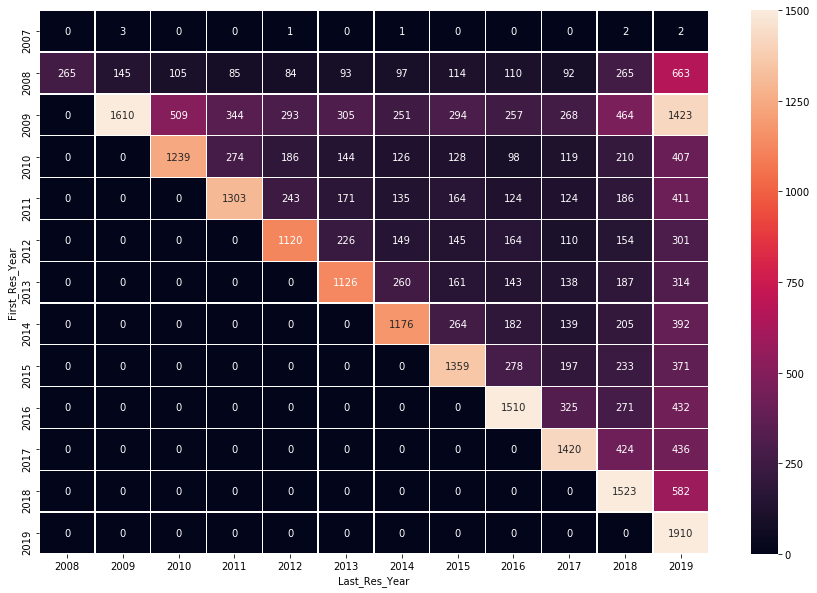

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = pd.crosstab(
    index=ek_info.First_Res_Year, columns=ek_info.Last_Res_Year
)

plt.figure(figsize=(15, 10))
sns.heatmap(data=plot_data, linewidths=0.3, vmax=1500, annot=True, fmt="d")

# Distribution of Auftragsart

In [15]:
display(
    pd.crosstab(
        index=[bd.Auftragsart, bd.Vertrag], columns=bd.Kamp_Erfass_Jahr, margins=True
    )
)
display("Netto-Umsatz")
display(
    bd.pivot_table(
        index=["Auftragsart", "Vertrag"],
        columns="Kamp_Erfass_Jahr",
        values="Netto",
        aggfunc="sum",
        fill_value=0,
        margins=True,
    )
)

,Kamp_Erfass_Jahr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Auftragsart,Vertrag,,,,,,,,,,,,,,
Aushangauftrag Partner,Nein,0,88,2003,1629,1745,2223,2703,1488,26,14,16,21,17,11973
Eigenwerbung APG,Nein,0,0,79,0,1,13,0,1,123,56,82,56,0,411
Goodwill,Nein,0,0,6,7,6,9,9,5,6,4,12,13,12,89
Karitativ,Nein,0,104,227,238,224,351,265,304,442,564,547,598,442,4306
Kommerziell,Nein,0,6078,34516,38627,39748,37761,36611,40953,43260,48152,50064,48986,42984,467740
Logistik für Dritte,Nein,0,0,0,0,4,13,6,31,387,353,371,378,283,1826
Politisch,Nein,0,354,1934,1773,4847,3068,2492,2733,5842,3536,3106,3275,4936,37896
Promotion,Nein,0,60,2283,1879,1728,1823,3048,1212,2102,2736,2965,3854,821,24511
Sponsoring,Nein,0,40,139,124,179,181,171,172,218,208,245,358,99,2134


'Netto-Umsatz'

,Kamp_Erfass_Jahr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Auftragsart,Vertrag,,,,,,,,,,,,,,
Aushangauftrag Partner,Nein,0,30444,849600,791206,739514,1026394,1000669,439344,110412,92214,117954,150966,98982,5447699
Eigenwerbung APG,Nein,0,0,3897655,0,4670,1048532,0,360,133390,126540,1222454,72427,0,6506028
Goodwill,Nein,0,0,6543,7939,4953,18668,2994,4762,4191,1732,17772,16741,9174,95469
Karitativ,Nein,0,724644,1960077,1628917,1866012,2668615,2253943,2318474,2578634,3459117,2775404,3962032,2788880,28984749
Kommerziell,Nein,0,33806952,148051046,162393013,168628594,175031787,158519973,182560236,193519765,204222602,197001081,191688278,186894495,2002317822
Logistik für Dritte,Nein,0,0,0,0,4600,184578,31589,132394,479850,420927,418245,522661,323055,2517899
Politisch,Nein,0,2040430,6938949,6463858,18562173,11082670,9945225,10458567,16977360,11414298,6379246,8489070,12324358,121076204
Promotion,Nein,0,1083041,5375644,4376195,3393104,3505266,5451654,3185928,3787542,4991362,4881049,9304271,2266906,51601962
Sponsoring,Nein,0,348746,1097029,1087749,2340803,2588788,3282531,3450304,3740079,3906123,3671259,3432667,819168,29765246


### Auftragsart vs. customers

In [16]:
%%time

ek_auftragsart = pd.crosstab(columns=bd.Auftragsart, index=bd.Endkunde_NR)
ek_auftragsart.mask(ek_auftragsart == 0, inplace=True)

ek_auftragsart.head(10)

Wall time: 3.4 s


Auftragsart,Aushangauftrag Partner,Eigenwerbung APG,Goodwill,Karitativ,Kommerziell,Logistik für Dritte,Politisch,Promotion,Sponsoring,Traffic Auftrag,Vertragsvorschrift (OC),langfristiger Vertrag
Endkunde_NR,,,,,,,,,,,,
100034,NaN,NaN,NaN,NaN,119.0,NaN,NaN,13.0,NaN,18.0,NaN,NaN
100039,NaN,NaN,NaN,NaN,50.0,NaN,NaN,1.0,NaN,17.0,NaN,NaN
100061,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100064,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,9.0,NaN,NaN
100066,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100083,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100092,NaN,NaN,NaN,NaN,27.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
100095,NaN,NaN,NaN,NaN,112.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN
100097,NaN,NaN,NaN,NaN,144.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN


How many **different** Auftragsart per customer?

In [17]:
ek_auftragsart.count(axis='columns').value_counts()

1    24075
2     5957
3     1797
4      386
5       36
6       10
7        2
8        1
dtype: int64

How many **most frequent** Auftragsart per customer? 

In [18]:
(ek_auftragsart.subtract(ek_auftragsart.max(axis='columns'), axis='index') == 0).sum(axis='columns').value_counts()

1    31494
2      752
3       18
dtype: int64

Where is the a **clear favourite** Auftragsart for a customer?

In [19]:
%%time
ek_auftragsart_scores = clear_row_max(ek_auftragsart)

Wall time: 22.4 s


In [20]:
ek_auftragsart_scoring = pd.DataFrame(
    index=ek_auftragsart_scores.index,
    data={"AufArt": ek_auftragsart_scores},
)

ek_auftragsart_scoring.dropna(inplace=True)

# Branchen

In [21]:
ek_branchen = ek_info.loc[:,['Endkunde_NR', 'EK_BG_ID', 'Auftrag_BG_ID']]

In [22]:
def unique_list(lst):
    return list(set(lst))


ek_branchen["Auftrag_BG_list"] = ek_branchen.Auftrag_BG_ID.str.split(",")
ek_branchen["BG_list"] = ek_branchen.apply(
    lambda x: unique_list([x.EK_BG_ID] + x.Auftrag_BG_list), axis="columns"
)
ek_branchen.drop(
    ["EK_BG_ID", "Auftrag_BG_ID", "Auftrag_BG_list"], axis="columns", inplace=True
)

In [23]:
display(ek_branchen.head())

ek_branchen_scoring = ek_branchen.explode(column="BG_list").rename(
    columns={"BG_list": "BG"}
)

display(ek_branchen_scoring.head())

,Endkunde_NR,BG_list
0,100034,"[295, 400, 405, 720]"
1,100039,"[720, 470]"
2,100061,[555]
3,100064,"[960, 901, 720]"
4,100066,"[780, 720]"


,Endkunde_NR,BG
0,100034,295
0,100034,400
0,100034,405
0,100034,720
1,100039,720


# Auftragsart vs. Branchen

In [24]:
AufArt_BG = ek_auftragsart_scoring.merge(ek_branchen_scoring, how='inner', on='Endkunde_NR')

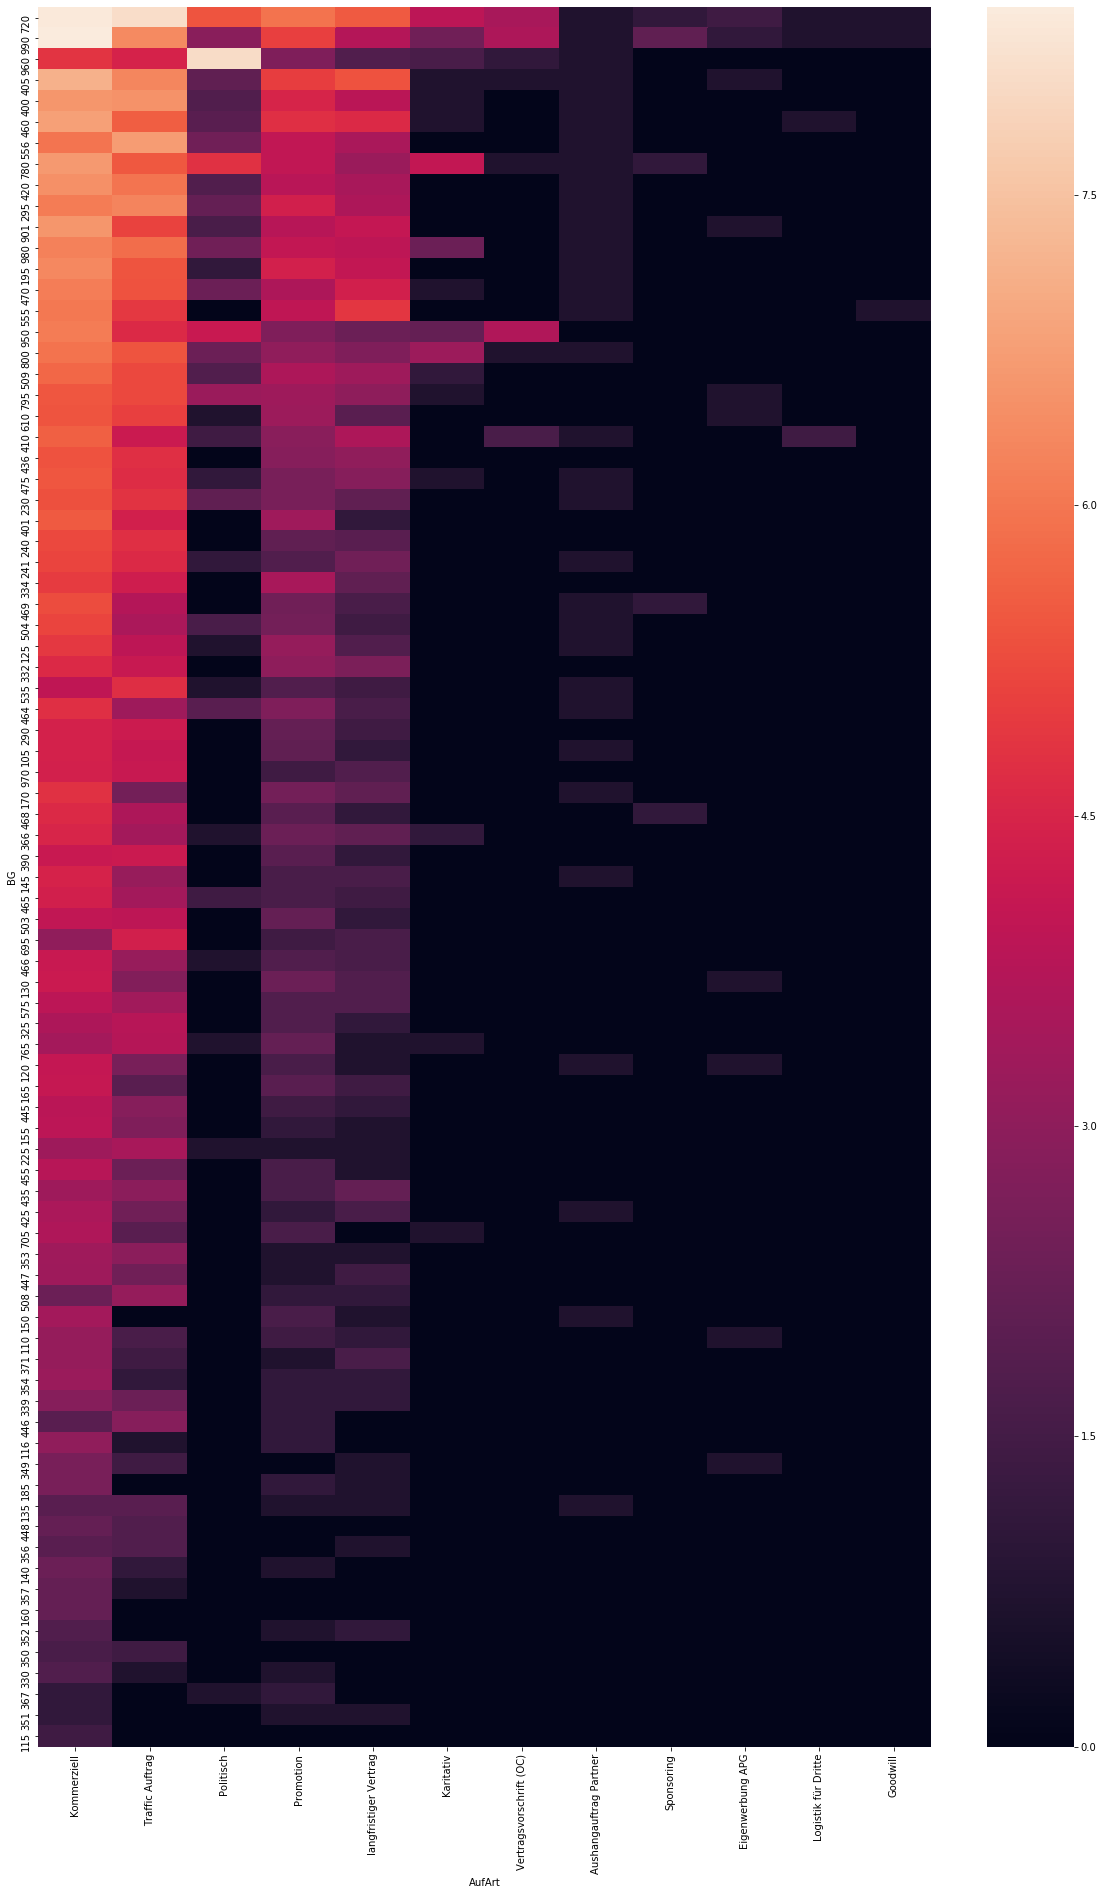

In [25]:
plt.figure(figsize=(20, 32))
sns.heatmap(
    data=np.log1p(
        pd.crosstab(columns=AufArt_BG.AufArt, index=AufArt_BG.BG, margins=True)
        .sort_values("All", ascending=False)
        .sort_values("All", axis="columns", ascending=False)
    ).iloc[1:,1:]
)

In [26]:
display(
    normalize_rows(
        pd.crosstab(columns=AufArt_BG.AufArt, index=AufArt_BG.BG, margins=True)
        .sort_values("All", ascending=False)
        .sort_values("All", axis="columns", ascending=False)
        .iloc[1:, 1:]
    )
)

AufArt,Kommerziell,Traffic Auftrag,Politisch,Promotion,langfristiger Vertrag,Karitativ,Vertragsvorschrift (OC),Aushangauftrag Partner,Sponsoring,Eigenwerbung APG,Logistik für Dritte,Goodwill
BG,,,,,,,,,,,,
720,0.503813,0.385248,0.026335,0.044685,0.029433,0.005720,0.003813,0.000119,0.000238,0.000357,0.000119,0.000119
990,0.842293,0.106955,0.003195,0.029135,0.007519,0.001880,0.006767,0.000188,0.001316,0.000376,0.000188,0.000188
960,0.036695,0.024270,0.931523,0.004045,0.001445,0.001156,0.000578,0.000289,0.000000,0.000000,0.000000,0.000000
405,0.584095,0.244059,0.003199,0.068099,0.098720,0.000457,0.000457,0.000457,0.000000,0.000457,0.000000,0.000000
400,0.471456,0.437460,0.003207,0.056446,0.030148,0.000641,0.000000,0.000641,0.000000,0.000000,0.000000,0.000000
460,0.642012,0.194527,0.004438,0.083580,0.073225,0.000740,0.000000,0.000740,0.000000,0.000000,0.000740,0.000000
556,0.299847,0.625767,0.007669,0.040644,0.025307,0.000000,0.000000,0.000767,0.000000,0.000000,0.000000,0.000000
780,0.614241,0.187011,0.092332,0.041471,0.018779,0.043036,0.000782,0.000782,0.001565,0.000000,0.000000,0.000000
420,0.581458,0.343834,0.004500,0.040504,0.028803,0.000000,0.000000,0.000900,0.000000,0.000000,0.000000,0.000000


# Restrict bookings to interesting customers (current & long-term)

### List of current long-time customers

* "Current" means that their last booking was not more than two years back. 
* "Long-time" means that they had at least two years of bookings.

In [27]:
limit_year = pd.Timestamp.today().year - 2

ek_nr_current = ek_info.loc[
    (ek_info.Last_Res_Year >= limit_year)
    & (ek_info.First_Res_Year < limit_year - 2),
    "Endkunde_NR"
]

In [38]:
bd_current = (
    bd.loc[bd.Endkunde_NR.isin(ek_nr_current)].pipe(clean_up_categoricals).copy()
)

print(f"Keeping {bd_current.shape[0]} of {bd.shape[0]} records")

Keeping 471812 of 675655 records


In [39]:
ek_info_current = ek_info.loc[ek_info.Endkunde_NR.isin(ek_nr_current)].copy()

print(f"Keeping {ek_info_current.shape[0]} of {ek_info.shape[0]} records")

Keeping 6576 of 32264 records


# Aggregate bookings per customer, year, and KW_2 / KW_4 period

Both by Reservation and Aushang.

In [30]:
def sum_calc(df, col_year, col_week):
    return (
        df.loc[:, ["Endkunde_NR", col_year, col_week, "Netto"]]
        .pipe(unfactorize)
        .groupby(["Endkunde_NR", col_year, col_week], observed=True, as_index=False)
        .agg({"Netto": ["sum"]})
        .set_axis(
            f"Endkunde_NR {col_year} {col_week} Netto_Sum".split(),
            axis="columns",
            inplace=False,
        )
    )


def aggregate_bookings(df, period):
    info(f"Period: {period}")
    info("Calculate Reservation...")
    df_res = sum_calc(df, "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}")
    info("Calculate Aushang...")
    df_aus = sum_calc(df, "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}")

    info("Merge Results...")
    df_aggr = df_res.merge(
        right=df_aus,
        left_on=["Endkunde_NR", "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}"],
        right_on=["Endkunde_NR", "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"],
        how="outer",
        suffixes=("_Res", "_Aus"),
    ).rename(
        {"Kamp_Erfass_Jahr": "Jahr", f"Kamp_Erfass_{period}": period}, axis="columns"
    )

    df_aggr = (
        df_aggr.fillna(
            {
                "Jahr": df_aggr.Kamp_Beginn_Jahr,
                period: df_aggr[f"Kamp_Beginn_{period}"],
                "Netto_Sum_Res": 0,
                "Netto_Sum_Aus": 0,
            }
        )
        .drop(["Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"], axis="columns")
        .astype({"Jahr": "int16"})
        .astype({period: "int8"})
        .sort_values(["Jahr", "Endkunde_NR", period])
        .reset_index(drop=True)
    )

    return df_aggr

In [31]:
bd_aggr_2w = aggregate_bookings(bd_current, 'KW_2')
bd_aggr_4w = aggregate_bookings(bd_current, 'KW_4')

2019-09-12 13:05:47 [INFO] Period: KW_2
2019-09-12 13:05:47 [INFO] Calculate Reservation...
2019-09-12 13:05:47 [INFO] Calculate Aushang...
2019-09-12 13:05:47 [INFO] Merge Results...
2019-09-12 13:05:47 [INFO] Period: KW_4
2019-09-12 13:05:47 [INFO] Calculate Reservation...
2019-09-12 13:05:48 [INFO] Calculate Aushang...
2019-09-12 13:05:48 [INFO] Merge Results...


In [32]:
bd_aggr_2w.head(10)

,Endkunde_NR,Jahr,KW_2,Netto_Sum_Res,Netto_Sum_Aus
0,103092,2007,45,5310.0,0.0
1,116266,2007,23,5700.0,0.0
2,177225,2007,45,2365.0,0.0
3,494878,2007,47,5900.0,0.0
4,100098,2008,39,16755.0,0.0
5,100143,2008,39,15000.0,0.0
6,100143,2008,49,2560.0,0.0
7,100166,2008,47,1007.0,0.0
8,100166,2008,49,40823.0,0.0
9,100166,2008,51,10431.0,1007.0


# Netto by customer / year

In [33]:
bd_aggr_yr = bd_aggr_2w.groupby(["Endkunde_NR", "Jahr"]).agg(
    {"Netto_Sum_Res": "sum", "Netto_Sum_Aus": "sum"}
)

bd_aggr_yr.head(15)

Netto_Sum_Res  Netto_Sum_Aus
Endkunde_NR Jahr                              
100034      2009        66453.0        66453.0
            2010        72769.0        72769.0
            2011        66019.0        66019.0
            2012        58270.0        58270.0
            2013        37232.0        37232.0
            2014        51182.0        51182.0
            2015        27084.0        27084.0
            2016        36496.0        36496.0
            2017        28648.0        28648.0
            2018        15037.0        15037.0
100039      2009        11970.0         9270.0
            2010         5967.0         5967.0
            2011        15065.0        15960.0
            2012         3500.0         5305.0
            2013        29537.0        29537.0

In [34]:
bd_aggr_yr_ek = bd_aggr_yr.groupby("Endkunde_NR").agg(["min", "max", "mean", "median"])

bd_aggr_yr_ek.head()

Netto_Sum_Res                                 Netto_Sum_Aus  \
                      min      max          mean   median           min   
Endkunde_NR                                                               
100034            15037.0  72769.0  45919.000000  44207.0       15037.0   
100039             3500.0  38960.0  18819.272727  17853.0        5305.0   
100064             1441.0   4155.0   2177.333333   2000.0        1441.0   
100066                0.0  10142.0   4768.000000   4465.0           0.0   
100083                0.0  90123.0  34420.800000  30517.0         880.0   

                                             
                 max          mean   median  
Endkunde_NR                                  
100034       72769.0  45919.000000  44207.0  
100039       38960.0  18819.272727  17853.0  
100064        4155.0   2177.333333   2000.0  
100066        7463.0   2232.500000    733.5  
100083       54477.0  34420.800000  35646.0

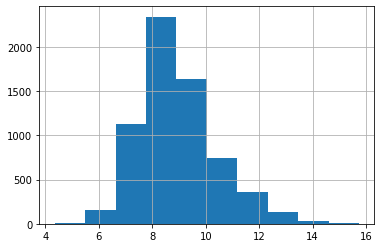

In [35]:
np.log1p(bd_aggr_yr_ek[('Netto_Sum_Res', 'mean')]).hist()

### Find good category borders for 5 categories

In [36]:
pd.qcut(bd_aggr_yr_ek[('Netto_Sum_Res', 'mean')].values, q=5).categories

IntervalIndex([(75.999, 2366.364], (2366.364, 4387.143], (4387.143, 8563.0], (8563.0, 22464.571], (22464.571, 6833248.25]],
              closed='right',
              dtype='interval[float64]')

### Cut the net values, label categories, merge back into ``ek_info_current`` 

In [40]:
_netto_cat = pd.cut(
    bd_aggr_yr_ek[("Netto_Sum_Res", "mean")],
    bins=(0, 4000, 10000, 50000, 500000, 7000000),
    labels="<4k 4k-10k 10k-50k 50k-500k >500k".split(),
).rename("netto_cat")

ek_info_current.loc[:,'Netto_Cat'] = ek_info_current.merge(_netto_cat, on='Endkunde_NR')['netto_cat'].values

In [41]:
ek_info_current.Netto_Cat.value_counts()

<4k         2436
4k-10k      1778
10k-50k     1661
50k-500k     630
>500k         71
Name: Netto_Cat, dtype: int64

# Calculate sum curve per customer * year, over periods

In [42]:
def make_year_grp_sumcurve(df, year_col, grp_col, data_col, prefix=""):
    # build new columns with sum/cumsum per year/grp
    df = df.pipe(
        calc_col_partitioned,
        f"{prefix}sumJahr",
        fun="sum",
        on=data_col,
        part_by=[year_col, grp_col],
    ).pipe(
        calc_col_partitioned,
        f"{prefix}cumJahr",
        fun="cumsum",
        on=data_col,
        part_by=[year_col, grp_col],
    )

    # divide data_col by sum to get scaled amounts, show in %
    df = (
        df.eval(f"{prefix}prcJahr = ({data_col} / {prefix}sumJahr) * 100 + 0.5")
        .fillna({f"{prefix}prcJahr": 0})
        .astype({f"{prefix}prcJahr": "int"})
    )

    # divide cumsum by sum to get sum curve [0, 1], show in %
    df = (
        df.eval(f"{prefix}crvJahr = ({prefix}cumJahr / {prefix}sumJahr) * 100 + 0.5")
        .fillna({f"{prefix}crvJahr": 0})
        .astype({f"{prefix}crvJahr": "int"})
    )
    return df

In [43]:
bd_aggr_2w = (
    bd_aggr_2w.pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Res",
        prefix="Res_",
    )
    .pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Aus",
        prefix="Aus_",
    )
    .sort_values(["Endkunde_NR", "Jahr", "KW_2"])
    .reset_index(drop=True)
)

bd_aggr_4w = (
    bd_aggr_4w.pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Res",
        prefix="Res_",
    )
    .pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Aus",
        prefix="Aus_",
    )
    .sort_values(["Endkunde_NR", "Jahr", "KW_4"])
    .reset_index(drop=True)
)

In [44]:
bd_aggr_2w.head(10)

,Endkunde_NR,Jahr,KW_2,Netto_Sum_Res,Netto_Sum_Aus,Res_sumJahr,Res_cumJahr,Res_prcJahr,Res_crvJahr,Aus_sumJahr,Aus_cumJahr,Aus_prcJahr,Aus_crvJahr
0,100034,2009,7,21834.0,0.0,66453.0,21834.0,33,33,66453.0,0.0,0,0
1,100034,2009,9,1400.0,0.0,66453.0,23234.0,2,35,66453.0,0.0,0,0
2,100034,2009,13,0.0,23234.0,66453.0,23234.0,0,35,66453.0,23234.0,35,35
3,100034,2009,17,3933.0,0.0,66453.0,27167.0,6,41,66453.0,23234.0,0,35
4,100034,2009,23,0.0,3933.0,66453.0,27167.0,0,41,66453.0,27167.0,6,41
5,100034,2009,39,9000.0,0.0,66453.0,36167.0,14,54,66453.0,27167.0,0,41
6,100034,2009,43,3770.0,9000.0,66453.0,39937.0,6,60,66453.0,36167.0,14,54
7,100034,2009,45,26516.0,0.0,66453.0,66453.0,40,100,66453.0,36167.0,0,54
8,100034,2009,47,0.0,30286.0,66453.0,66453.0,0,100,66453.0,66453.0,46,100
9,100034,2010,9,22495.0,0.0,72769.0,22495.0,31,31,72769.0,0.0,0,0


In [45]:
bd_aggr_4w.head(10)

,Endkunde_NR,Jahr,KW_4,Netto_Sum_Res,Netto_Sum_Aus,Res_sumJahr,Res_cumJahr,Res_prcJahr,Res_crvJahr,Aus_sumJahr,Aus_cumJahr,Aus_prcJahr,Aus_crvJahr
0,100034,2009,5,21834.0,0.0,66453.0,21834.0,33,33,66453.0,0.0,0,0
1,100034,2009,9,1400.0,0.0,66453.0,23234.0,2,35,66453.0,0.0,0,0
2,100034,2009,13,0.0,23234.0,66453.0,23234.0,0,35,66453.0,23234.0,35,35
3,100034,2009,17,3933.0,0.0,66453.0,27167.0,6,41,66453.0,23234.0,0,35
4,100034,2009,21,0.0,3933.0,66453.0,27167.0,0,41,66453.0,27167.0,6,41
5,100034,2009,37,9000.0,0.0,66453.0,36167.0,14,54,66453.0,27167.0,0,41
6,100034,2009,41,3770.0,9000.0,66453.0,39937.0,6,60,66453.0,36167.0,14,54
7,100034,2009,45,26516.0,30286.0,66453.0,66453.0,40,100,66453.0,66453.0,46,100
8,100034,2010,9,22495.0,0.0,72769.0,22495.0,31,31,72769.0,0.0,0,0
9,100034,2010,13,0.0,22495.0,72769.0,22495.0,0,31,72769.0,22495.0,31,31


### Store and reload results

In [46]:
store_bin(bd_aggr_2w, 'bd_cluster_aggr_2w.feather')
store_bin(bd_aggr_4w, 'bd_cluster_aggr_4w.feather')

2019-09-12 13:12:47 [INFO] Writing to file C:\Users\kpf\data\vkprog\bd_cluster_aggr_2w.feather
2019-09-12 13:12:47 [INFO] Written 14.0 MB
2019-09-12 13:12:47 [INFO] Finished storing binary file in 0.02s (0.16s CPU)
2019-09-12 13:12:47 [INFO] Writing to file C:\Users\kpf\data\vkprog\bd_cluster_aggr_4w.feather
2019-09-12 13:12:47 [INFO] Written 12.2 MB
2019-09-12 13:12:47 [INFO] Finished storing binary file in 0.02s (0.09s CPU)


In [47]:
bd_aggr_2w = load_bin('bd_cluster_aggr_2w.feather')
bd_aggr_4w = load_bin('bd_cluster_aggr_4w.feather')

2019-09-12 13:12:48 [INFO] Reading from file C:\Users\kpf\data\vkprog\bd_cluster_aggr_2w.feather
2019-09-12 13:12:48 [INFO] Finished loading binary file in 0.01s (0.11s CPU)
2019-09-12 13:12:48 [INFO] Reading from file C:\Users\kpf\data\vkprog\bd_cluster_aggr_4w.feather
2019-09-12 13:12:48 [INFO] Finished loading binary file in 0.0s (0.0s CPU)


# Clustering Customers by Reservation

### Drop incomplete years

We have data for the last 10 years, the current year is incomplete

In [48]:
current_year = pd.Timestamp.today().year
valid_years = list(range(current_year - 10, current_year))
valid_years

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

### Pivot prc values by period

In [49]:
bd_res_prc_2w_data = bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))].pivot_table(
    index=["Endkunde_NR", "Jahr"],
    columns="KW_2",
    values="Res_prcJahr",
    aggfunc="sum",
    fill_value=0,
)

# drop years with no reservations
bd_res_prc_2w_data = bd_res_prc_2w_data.loc[bd_res_prc_2w_data.sum(axis="columns") > 0]

bd_res_prc_2w_data.head(12)

KW_2              1   3   5   7   9   11  13  15  17  19  21  23  25  27  29  \
Endkunde_NR Jahr                                                               
100034      2009   0   0   0  33   2   0   0   0   6   0   0   0   0   0   0   
            2010   0   0   0   0  31   0   0   0   0   0   0   0   0   0  12   
            2011   0   0   0   0  40   0   0   0   0   0   0   0   0   0   0   
            2012   0   0   0   0  29   0   0   0   0   0   0   0   0   0   8   
            2013   0   0  52   2   0   0   0   0   0   0   0   0   0   0   0   
            2014   0  40   2   0   0   0   0   0   0   0   0   0   0   0   0   
            2015   0   0  44   0   0   0   0   0   0   0   0   0   0   0   0   
            2016   0  57   0   0   0   0   0   0   0   0   0   0   0   0   0   
            2017   0   0  28   0   0   0   0   0   0   0   0   0   0   0   0   
            2018   0   0  26   0   0   0   0   0   0   0   0   0   0   0   0   
100039      2009  23   0   0   0   0   0  55   0   0   0   0   0   0   0   0   
            2010   0   0   0   0   0   0   0   0  55   0   0   0   0   0   0   

KW_2              31  33  35  37  39  41  43  45  47  49  51  
Endkunde_NR Jahr                                              
100034      2009   0   0   0   0  14   0   6  40   0   0   0  
            2010   0   0   0   0   0   0  57   0   0   0   0  
            2011  14   0   0   0   4   2  41   0   0   0   0  
            2012   9   0   0   0   0   0  51   2   0   0   0  
            2013  14   0   0   0   0   0  32   0   0   0   0  
            2014   0   0   0   0   0   0  58   0   0   0   0  
            2015   0   0   0   0   0   0  51   5   0   0   0  
            2016   0   0   0   0   0  39   4   0   0   0   0  
            2017   0   0   0   0   0  26  47   0   0   0   0  
            2018   0   0   0   0   0   0  74   0   0   0   0  
100039      2009   0   0   0   0   0   0   0   0   0   0  23  
            2010   0   0   0   0   0   0   0   0   0   0  45

### Prepare data: Aggregate over years by customer

In [ ]:
ek_2w_prc_mean = (
    bd_res_prc_2w_data.reset_index()
    .drop("Jahr", axis="columns")
    .groupby("Endkunde_NR")
    .agg("mean")
)

# correct rowsums to 100
ek_2w_prc_mean = (normalize_rows(ek_2w_prc_mean) * 100)

ek_2w_prc_mean_stack = (
    ek_2w_prc_mean.stack()
    .reset_index()
    .set_axis(["Endkunde_NR", "KW_2", "prc_mean"], axis="columns", inplace=False)
)

display(ek_2w_prc_mean.round(1).head(10))

### Pivot crv values by period

In [ ]:
bd_res_crv_2w_data = (
    bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))]
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="KW_2",
        values="Res_crvJahr",
        aggfunc="sum",
    )
    .fillna(method="ffill", axis=1)
    .fillna(0)
)

# drop years with no reservations
bd_res_crv_2w_data = bd_res_crv_2w_data.loc[bd_res_crv_2w_data.sum(axis="columns") > 0]

### Aggregate over years by customer

In [ ]:
ek_2w_crv_mean = (
    bd_res_crv_2w_data.reset_index()
    .drop("Jahr", axis="columns")
    .groupby("Endkunde_NR")
    .agg("mean")
)

ek_2w_crv_mean_stack = (
    ek_2w_crv_mean.stack()
    .reset_index()
    .set_axis(["Endkunde_NR", "KW_2", "crv_mean"], axis="columns", inplace=False)
)

display(bd_res_crv_2w_data.head())
display(ek_2w_crv_mean.head())
ek_2w_crv_mean_stack.head()

### Plot customer booking patterns (global)

In [ ]:
import seaborn as sns
%matplotlib inline

sns.set()
sns.catplot(
    data=ek_2w_prc_mean_stack, x="KW_2", y="prc_mean", aspect=2.5, kind="boxen"
)

In [ ]:
sns.catplot(
    data=ek_2w_crv_mean_stack, x="KW_2", y="crv_mean", aspect=2.5, kind="boxen"
)

### Cluster booking patterns (percentage of yearly sum)

Prepare data

In [ ]:
X = ek_2w_prc_mean.to_numpy()

X_columns = ek_2w_prc_mean.columns

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in range(5, 21):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

In [ ]:
nkmeans = KMeans(n_clusters=15, random_state=0, verbose=1, n_jobs=-1)

prc_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(prc_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(20, 10))
sns.heatmap(nkmeans_clusters, annot=True, vmin=1, vmax=5)

Cluster sizes

In [ ]:
pd.Series(prc_nkmeans_labels).value_counts()

Plot scaled bookings by cluster

In [ ]:
plot_data = ek_2w_prc_mean_stack.merge(
    pd.Series(data=prc_nkmeans_labels, index=ek_2w_prc_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc_mean",
    aspect=1.1,
    kind="boxen",
    col="cluster",
    col_wrap=4,
    col_order=pd.Series(prc_nkmeans_labels).value_counts().index,  # order by cluster size
    height=4,
)

### Cluster booking patterns (cumulative percentage of yearly sum)

Prepare data

In [ ]:
X = ek_2w_crv_mean.to_numpy()

X_columns = ek_2w_crv_mean.columns

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in range(3, 21):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

In [ ]:
nkmeans = KMeans(n_clusters=15, random_state=0, verbose=1, n_jobs=-1)

crv_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(crv_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(20, 10))
sns.heatmap(nkmeans_clusters, annot=True)

Cluster sizes

In [ ]:
pd.Series(crv_nkmeans_labels).value_counts()

Plot scaled bookings by cluster

In [ ]:
plot_data = ek_2w_prc_mean_stack.merge(
    pd.Series(data=crv_nkmeans_labels, index=ek_2w_crv_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc_mean",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    col_order=pd.Series(crv_nkmeans_labels).value_counts().index, # order by cluster size
    height=4,
)

# PCA on Customers

### Prepare Data

In [ ]:
X = ek_2w_crv_mean.to_numpy()
X_columns = ek_2w_crv_mean.columns
X_index = ek_2w_crv_mean.index

y = crv_nkmeans_labels

### Calculate standard PCA with 4 components

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4, random_state=0)
X_pca = pca.fit_transform(X)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.components_

### Plot K-means clusters against principal components

In [ ]:
plot_data = pd.DataFrame(X_pca, index=X_index, columns=range(1, pca.n_components + 1))
plot_data["clusters"] = y
sns.set(style="ticks")
sns.pairplot(data=plot_data, hue="clusters", plot_kws={"alpha": 0.4})

# Clustering Customer Booking Years

### Prepare data: Pivot prc values by period

In [ ]:
bd_res_prc_2w_data = bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))].pivot_table(
    index=["Endkunde_NR", "Jahr"],
    columns="KW_2",
    values="Res_prcJahr",
    aggfunc="sum",
    fill_value=0,
)

# drop years with no reservations
bd_res_prc_2w_data = bd_res_prc_2w_data.loc[bd_res_prc_2w_data.sum(axis="columns") > 0]

bd_res_prc_2w_data_stack = bd_res_prc_2w_data.stack()

bd_res_prc_2w_data.head(12)

In [ ]:
X = bd_res_prc_2w_data.to_numpy()

X_columns = bd_res_prc_2w_data.columns
X_index = bd_res_prc_2w_data.index

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in range(25, 31):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

In [ ]:
nkmeans = KMeans(n_clusters=27, random_state=0, verbose=1, n_jobs=-1)

yr_prc_nkmeans_labels = nkmeans.fit_predict(X)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

yr_prc_nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(yr_prc_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(25, 16))
sns.heatmap(yr_prc_nkmeans_clusters, annot=True, vmin=0, vmax=7)

In [ ]:
pd.Series(yr_prc_nkmeans_labels).value_counts() # / yr_prc_nkmeans_labels.shape[0]

In [ ]:
plot_data = (
    pd.DataFrame.from_dict({"prc": bd_res_prc_2w_data_stack})
    .reset_index()
    .merge(
        pd.Series(
            data=yr_prc_nkmeans_labels, index=bd_res_prc_2w_data.index, name="cluster"
        ),
        on=["Endkunde_NR", "Jahr"],
    )
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    height=4,
)

### Clusters matched to customers

In [ ]:
ek_prc_cls = pd.crosstab(
    index=bd_res_prc_2w_data.reset_index()["Endkunde_NR"],
    columns=pd.Series(yr_prc_nkmeans_labels, name="cluster"),
)

ek_prc_cls_yr_cnt_ = ek_prc_cls.copy()


def cls_list(s):
    return list(s.loc[s > 0].index.values)


def main_cls_list(s):
    return list(s.loc[s == np.max(s)].index.values)


ek_prc_cls = ek_prc_cls.assign(
    n_yr=ek_prc_cls_yr_cnt_.sum(axis="columns"),
    n_cls=ek_prc_cls_yr_cnt_.where(ek_prc_cls > 0).count(axis="columns"),
    cls=ek_prc_cls_yr_cnt_.apply(cls_list, axis="columns"),
    main_cls=ek_prc_cls_yr_cnt_.apply(main_cls_list, axis="columns"),
)
ek_prc_cls["n_main_cls"] = ek_prc_cls["main_cls"].apply(len)

ek_prc_cls

### Customers that can be related to 1 or 2 clusters

In [ ]:
max_main_cls = 2

ek_clust_scoring = ek_prc_cls.query('n_main_cls < n_cls and n_main_cls <= @max_main_cls')[['main_cls']]

### Prepare data: Pivot crv values by period

In [ ]:
bd_res_crv_2w_data = (
    bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))]
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="KW_2",
        values="Res_crvJahr",
        aggfunc="sum",
    )
    .fillna(method="ffill", axis=1)
    .fillna(0)
)

# drop years with no reservations
bd_res_crv_2w_data = bd_res_crv_2w_data.loc[bd_res_crv_2w_data.sum(axis="columns") > 0]

bd_res_crv_2w_data_stack = bd_res_crv_2w_data.stack()

bd_res_crv_2w_data.head(12)

### Prepare for clustering

In [ ]:
X = bd_res_crv_2w_data.to_numpy()

X_columns = bd_res_crv_2w_data.columns
X_index = bd_res_crv_2w_data.index

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
for n_clusters in [15, 25, 35, 40]:
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

```
For n_clusters = 5: Silhouette_score = 0.3049945347740261,  CH score = 29630.89896114061
For n_clusters = 10: Silhouette_score = 0.366230862992324,  CH score = 26973.062027368196
For n_clusters = 15: Silhouette_score = 0.40334656127747526,  CH score = 25417.006073311764
For n_clusters = 20: Silhouette_score = 0.44202548618962784,  CH score = 24818.708849953175
For n_clusters = 25: Silhouette_score = 0.5033501558327148,  CH score = 24748.31007457299
For n_clusters = 30: Silhouette_score = 0.5602936199726821,  CH score = 25025.39923837368
For n_clusters = 35: Silhouette_score = 0.6095264482491675,  CH score = 26642.345879735167
For n_clusters = 40: Silhouette_score = 0.6171105582735361,  CH score = 26586.30470955651
```

In [ ]:
nkmeans = KMeans(n_clusters=27, random_state=0, verbose=1, n_jobs=-1)

yr_crv_nkmeans_labels = nkmeans.fit_predict(X)

### Show cluster centroids

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

yr_nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns)

plt.figure(figsize=(25, 16))
sns.heatmap(yr_nkmeans_clusters, annot=True, vmin=5)

### Cluster sizes

In [ ]:
pd.Series(yr_crv_nkmeans_labels).value_counts()

In [ ]:
plot_data = (
    pd.DataFrame.from_dict({"prc": bd_res_prc_2w_data_stack})
    .reset_index()
    .merge(
        pd.Series(
            data=yr_crv_nkmeans_labels, index=bd_res_crv_2w_data.index, name="cluster"
        ),
        on=["Endkunde_NR", "Jahr"],
    )
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    height=4,
)

### Clusters matched to customers

In [ ]:
ek_cls = pd.crosstab(
    index=bd_res_crv_2w_data.reset_index()["Endkunde_NR"],
    columns=pd.Series(yr_crv_nkmeans_labels, name="cluster"),
)

ek_cls_yr_cnt_ = ek_cls.copy()


def cls_list(s):
    return list(s.loc[s > 0].index.values)


def main_cls_list(s):
    return list(s.loc[s == np.max(s)].index.values)


ek_cls = ek_cls.assign(
    n_yr=ek_cls_yr_cnt_.sum(axis="columns"),
    n_cls=ek_cls_yr_cnt_.where(ek_cls > 0).count(axis="columns"),
    cls=ek_cls_yr_cnt_.apply(cls_list, axis="columns"),
    main_cls=ek_cls_yr_cnt_.apply(main_cls_list, axis="columns"),
)
ek_cls["n_main_cls"] = ek_cls["main_cls"].apply(len)

ek_cls

### Customers that can be assigned to 1 or 2 clusters

In [ ]:
max_main_cls = 2

yr_clust_scoring = ek_cls.query('n_main_cls < n_cls and n_main_cls <= @max_main_cls')[['main_cls']]

# Compare scoring between customer layer and year layer

In [ ]:
len(np.unique(ek_clust_scoring.index.values))

In [ ]:
len(np.unique(yr_clust_scoring.index.values))

In [ ]:
pd.DataFrame({"ek": np.unique(ek_clust_scoring.index.values)}).merge(
    pd.DataFrame({"ek": np.unique(yr_clust_scoring.index.values)}),
    how="outer",
    on="ek",
    indicator=True,
)["_merge"].value_counts()

# Cluster Scoring vs. Auftragsart

In [ ]:
AufArt_Clust = (
    ek_auftragsart_scoring.merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
pd.crosstab(columns=AufArt_Clust.AufArt, index=AufArt_Clust.Clust)

In [ ]:
plt.figure(figsize=(16, 20))
sns.heatmap(
    data=np.log1p(pd.crosstab(columns=AufArt_Clust.AufArt, index=AufArt_Clust.Clust)),
    annot=pd.crosstab(columns=AufArt_Clust.AufArt, index=AufArt_Clust.Clust),
    fmt="d"
)

# Cluster Scoring vs. Branchengruppe

In [ ]:
BG_Clust = (
    ek_branchen_scoring.merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
pd.crosstab(columns=BG_Clust.Clust, index=BG_Clust.BG, margins=True)

In [ ]:
plt.figure(figsize=(16, 32))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=BG_Clust.Clust, index=BG_Clust.BG)),
    annot=pd.crosstab(columns=BG_Clust.Clust, index=BG_Clust.BG),
    fmt="d",
    vmax=0.4
)

# Cluster Scoring vs. Kanton

In [ ]:
with project_dir('Raumgliederung'):
    ek_region = load_bin('ek_region.feather')

In [ ]:
ek_region.head()

In [ ]:
Kt_Clust = (
    ek_region[["Endkunde_NR", "KANTON"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 16))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=Kt_Clust.Clust, index=Kt_Clust.KANTON)),
    annot=pd.crosstab(columns=Kt_Clust.Clust, index=Kt_Clust.KANTON),
    fmt="d",
    #vmax=0.4
)

# Cluster Scoring vs. Grossregion

In [ ]:
GrReg_Clust = (
    ek_region[["Endkunde_NR", "GROSSREGION"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=GrReg_Clust.Clust, index=GrReg_Clust.GROSSREGION)),
    annot=pd.crosstab(columns=GrReg_Clust.Clust, index=GrReg_Clust.GROSSREGION),
    fmt="d",
)

# Cluster Scoring vs. Region

In [ ]:
Reg_Clust = (
    ek_region[["Endkunde_NR", "REGION"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 32))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=Reg_Clust.Clust, index=Reg_Clust.REGION)),
    annot=pd.crosstab(columns=Reg_Clust.Clust, index=Reg_Clust.REGION),
    fmt="d",
)

# Cluster Scoring vs. Netto-Umsatz

In [ ]:
Netto_Clust = (
    ek_info_current[["Endkunde_NR", "netto_cat"]]
    .merge(yr_clust_scoring.explode(column="main_cls"), how="inner", on="Endkunde_NR")
    .rename(columns={"main_cls": "Clust"})
)

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(
    data=normalize_rows(pd.crosstab(columns=Netto_Clust.Clust, index=Netto_Clust.netto_cat)),
    annot=pd.crosstab(columns=Netto_Clust.Clust, index=Netto_Clust.netto_cat),
    fmt="d",
)

# Map cluster scorings to periods, where appropriate

## Years, clustered by prc

In [ ]:
ek_clusters = (pd.DataFrame.from_dict({"prc": bd_res_prc_2w_data_stack})
    .reset_index()
    .merge(
        pd.Series(
            data=yr_prc_nkmeans_labels, index=bd_res_prc_2w_data.index, name="yr_prc_clust"
        ),
        on=["Endkunde_NR", "Jahr"],
    ))

ek_clusters.head()